<a href="https://colab.research.google.com/github/annulet/nn/blob/master/hw_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Вариант 2
1. Провести добучение UNet на всех доступных примерах кроме 5-ти последних до начала переобучения (callbacks)
2. оценить точность по коэффициенту Дици

In [1]:
# Подключение к Google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.datasets import mnist
from keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from keras import backend as K
from keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
from keras.utils import plot_model

Using TensorFlow backend.


In [0]:
import os, fnmatch

In [0]:
imag_in = os.listdir('/content/drive/My Drive/segmentation/images/')

In [0]:
imag_in.sort()

In [6]:
imag_in

['0001TP_006690.png',
 '0001TP_006720.png',
 '0001TP_006750.png',
 '0001TP_006780.png',
 '0001TP_006810.png',
 '0001TP_006840.png',
 '0001TP_006870.png',
 '0001TP_006900.png',
 '0001TP_006930.png',
 '0001TP_006960.png',
 '0001TP_006990.png',
 '0001TP_007020.png',
 '0001TP_007050.png',
 '0001TP_007080.png',
 '0001TP_007110.png',
 '0001TP_007140.png',
 '0001TP_007170.png',
 '0001TP_007200.png',
 '0001TP_007230.png',
 '0001TP_007260.png']

In [7]:
len(imag_in)

20

In [0]:
imag_out = os.listdir('/content/drive/My Drive/segmentation/annotations_prepped_train/')

In [0]:
imag_out.sort()

In [10]:
len(imag_out)

20

In [11]:
images = []
for i_name in imag_in:
  print(i_name)
  images.append(image.load_img('/content/drive/My Drive/segmentation/images/'+i_name, target_size=(352, 480)))

0001TP_006690.png
0001TP_006720.png
0001TP_006750.png
0001TP_006780.png
0001TP_006810.png
0001TP_006840.png
0001TP_006870.png
0001TP_006900.png
0001TP_006930.png
0001TP_006960.png
0001TP_006990.png
0001TP_007020.png
0001TP_007050.png
0001TP_007080.png
0001TP_007110.png
0001TP_007140.png
0001TP_007170.png
0001TP_007200.png
0001TP_007230.png
0001TP_007260.png


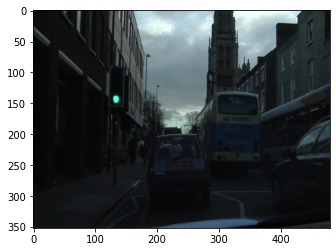

In [12]:
plt.imshow(images[0].convert('RGBA'))
plt.show()

In [13]:
segments = []
for i_name in imag_out:
  print(i_name)
  segments.append(image.load_img('/content/drive/My Drive/segmentation/annotations_prepped_train/'+i_name, target_size=(352, 480)))

0001TP_006690.png
0001TP_006720.png
0001TP_006750.png
0001TP_006780.png
0001TP_006810.png
0001TP_006840.png
0001TP_006870.png
0001TP_006900.png
0001TP_006930.png
0001TP_006960.png
0001TP_006990.png
0001TP_007020.png
0001TP_007050.png
0001TP_007080.png
0001TP_007110.png
0001TP_007140.png
0001TP_007170.png
0001TP_007200.png
0001TP_007230.png
0001TP_007260.png


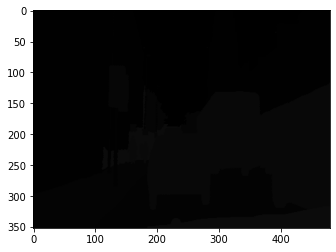

In [14]:
plt.imshow(segments[0].convert('RGBA'))
plt.show()

In [15]:
xTrain = []

for img in images:
  x = image.img_to_array(img)
  xTrain.append(x)

xTrain = np.array(xTrain)

print(xTrain.shape)

(20, 352, 480, 3)


In [0]:
yTrain = []

for seg in segments:
  y = image.img_to_array(seg)
  yTrain.append(y)

yTrain = np.array(yTrain)

In [0]:
def index2Color(index):
  
  color = (0,0,0)
  if (index == 0): color = (200, 0, 0)
  if (index == 1): color = (0, 200, 0)
  if (index == 2): color = (0, 0, 200)
  if (index == 3): color = (200, 200, 0)
  if (index == 4): color = (200, 0, 200)
  if (index == 5): color = (0, 200, 0)
  if (index == 6): color = (200, 200, 200)
  if (index == 7): color = (100, 0, 0)
  if (index == 8): color = (0, 100, 0)
  if (index == 9): color = (0, 0, 100)
  if (index == 10): color = (100, 100, 0)
  if (index == 11): color = (0, 100, 100)
    
  return color

In [0]:
outY = []

for pr in yTrain:
  currPr = pr.copy()
  currMatr = []
  for i in range(currPr.shape[0]):
    currStr = []
    for j in range(currPr.shape[1]):
      currStr.append(index2Color(currPr[i][j][0]))
    currMatr.append(currStr)
  outY.append(currMatr)

outY = np.array(outY)
outY = outY.astype('uint8')

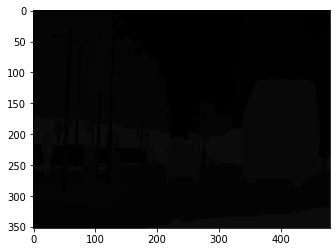

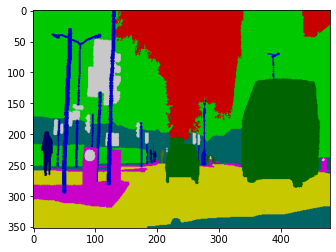

In [19]:
n = 10
plt.imshow(segments[n].convert('RGBA'))
plt.show()
img = Image.fromarray(outY[n])
plt.imshow(img.convert('RGBA'))
plt.show()

In [0]:
yTrain12 = []
for t in range(yTrain.shape[0]):
  yy = yTrain[t].copy()
  yyNew = []

  for i in range(yy.shape[0]):
    currYYstr = []
    for j in range(yy.shape[1]):
      currYYstr.append(utils.to_categorical(yy[i][j][0], 12))
    yyNew.append(currYYstr)

  yyNew = np.array(yyNew)
  yTrain12.append(yyNew)

yTrain12 = np.array(yTrain12)

In [0]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [0]:
def unet(num_classes=12, input_shape=(352, 480, 3)):
    img_input = tf.keras.layers.Input(input_shape)

    # Block 1
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    block_1_out = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.MaxPooling2D()(block_1_out)

    # Block 2
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    block_2_out = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.MaxPooling2D()(block_2_out)

    # Block 3
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    block_3_out = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.MaxPooling2D()(block_3_out)

    # Block 4
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    block_4_out = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.MaxPooling2D()(block_4_out)

    # Block 5
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)


    # # Load pretrained weights.
    # for_pretrained_weight = tf.keras.layers.MaxPooling2D()(x)
    # vgg16 = tf.keras.Model(img_input, for_pretrained_weight)
    # vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    x = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.concatenate([x, block_4_out])
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # UP 2
    x = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.concatenate([x, block_3_out])
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # UP 3
    x = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.concatenate([x, block_2_out])
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # UP 4
    x = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.concatenate([x, block_1_out])
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = tf.keras.Model(img_input, x)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [23]:
modelU = unet(12, (352, 480, 3))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 352, 480, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 352, 480, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 352, 480, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 352, 480, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

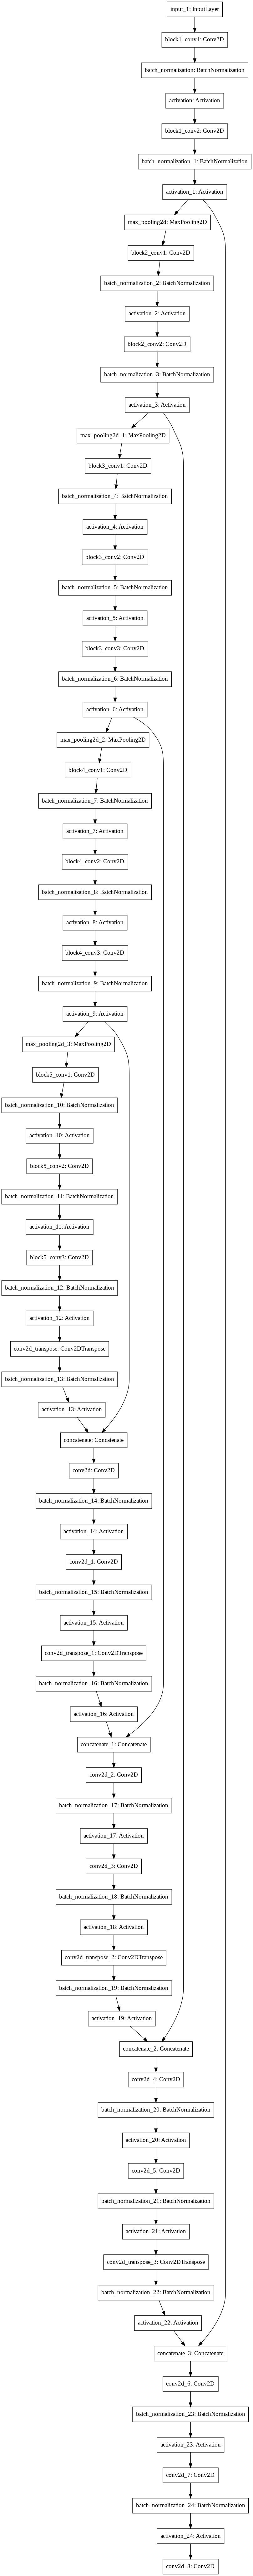

In [24]:
tf.keras.utils.plot_model(modelU, to_file='modelU.png')

In [46]:
history = modelU.fit(xTrain[:15], yTrain12[:15], epochs=50, batch_size=5, validation_data=(xTrain[15:], yTrain12[15:]))

Epoch 1/50
3/3 [==============================] - 1s 373ms/step - loss: 0.1051 - dice_coef: 0.9420 - val_loss: 1.7457 - val_dice_coef: 0.6554
Epoch 2/50
3/3 [==============================] - 1s 368ms/step - loss: 0.0924 - dice_coef: 0.9473 - val_loss: 1.8817 - val_dice_coef: 0.6569
Epoch 3/50
3/3 [==============================] - 1s 374ms/step - loss: 0.0929 - dice_coef: 0.9472 - val_loss: 1.8115 - val_dice_coef: 0.6522
Epoch 4/50
3/3 [==============================] - 1s 374ms/step - loss: 0.0880 - dice_coef: 0.9499 - val_loss: 1.6587 - val_dice_coef: 0.6661
Epoch 5/50
3/3 [==============================] - 1s 373ms/step - loss: 0.0835 - dice_coef: 0.9517 - val_loss: 1.4344 - val_dice_coef: 0.7047
Epoch 6/50
3/3 [==============================] - 1s 372ms/step - loss: 0.0777 - dice_coef: 0.9558 - val_loss: 1.3723 - val_dice_coef: 0.7153
Epoch 7/50
3/3 [==============================] - 1s 369ms/step - loss: 0.0781 - dice_coef: 0.9551 - val_loss: 1.3542 - val_dice_coef: 0.7033
Epoch 

In [0]:
pred = modelU.predict(xTrain)

In [0]:
out = []

for pr in pred:
  currPr = pr.copy()
  currMatr = []
  for i in range(currPr.shape[0]):
    currStr = []
    for j in range(currPr.shape[1]):
      currStr.append(index2Color(np.argmax(currPr[i][j])))
    currMatr.append(currStr)
  out.append(currMatr)

out = np.array(out)
out = out.astype('uint8')

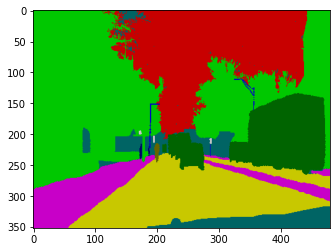

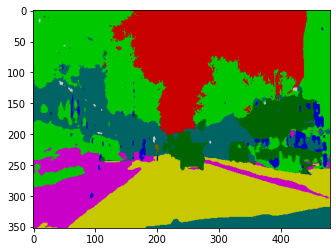

In [49]:
n = 16
img = Image.fromarray(outY[n])
plt.imshow(img.convert('RGBA'))
plt.show()
img = Image.fromarray(out[n])
plt.imshow(img.convert('RGBA'))
plt.show()

Коэффициент Дици на тесте

In [50]:
float(dice_coef(yTrain12[15:], pred[15:]))

0.7381600737571716

Мне кажется, что удалось достичь более-менее приемлемого качества, учитывая размер обучающей выборки.